# 1-in-10-year event

Assessment of model extreme events.

In [15]:
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

sys.path.append('/g/data/xv83/users/at2708/bias_adjustment/evaluation/npcp/results')
import utils

In [16]:
def calc_extreme(da, var):
    """Calculate the 1-in-10-year event"""

    def ari_to_quantile(ari, mode):
        """Average recurrence interval to quantile"""    
        if mode == 'max':
            quantile = 1 - (1. / ari)
        elif mode == 'min':
            quantile = 1. / ari
        else:
            raise ValueError('Invalid mode')         
        return quantile
   
    ari=10
    if var == 'pr' or var == 'tasmax':
        mode = 'extreme high'
        da = da.groupby('time.year').max()   
        mode_quan = 'max'
        quantile = ari_to_quantile(ari, mode_quan)
        ext = da.chunk({'year': -1}).quantile(quantile, dim='year')
    else:
        mode = 'extreme low'
        da = da.groupby('time.year').min()      
        mode_quan = 'min'
        quantile = ari_to_quantile(ari, mode_quan)
        ext = da.chunk({'year': -1}).quantile(quantile, dim='year')
          
    return ext, mode

In [17]:
def get_data(var, gcm, rcm, task):
    """Get data needed for the evaluation"""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    assert task in ['historical', 'xvalidation']
    
    if gcm == 'ECMWF-ERA5':
        start_date = '2000-01-01' if task == 'xvalidation' else '1980-01-01'
    else:
        start_date = '1990-01-01' if task == 'xvalidation' else '1980-01-01' 
    end_date = '2019-12-31'
    
    da_dict = {}
    
    da_dict['obs'] = utils.get_npcp_data(
        var,
        'observations',
        'AGCD',
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
   
    da_dict['gcm'] = utils.get_npcp_data(
        var,
        gcm,
        'GCM',
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
    da_dict['rcm_raw'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
    da_dict['rcm_ecdfm'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'ecdfm',
        f'task-{task}',
        start_date,
        end_date,
        'AU'
    )
    da_dict['rcm_qme'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'qme',
        f'task-{task}',
        start_date,
        end_date,
        'AU'
    )
    if task == 'xvalidation':
        da_dict['rcm_qdm'] = utils.get_npcp_data(
            var,
            gcm,
            rcm,
            'qdm',
            f'task-{task}',
            start_date,
            end_date,
            'AU'
        )
        
    # TODO: Add additional bias correction methods as data becomes available 

    return da_dict

In [18]:
def plot_mean_bias(ax, da_obs, da_model, var, cmap, levels, model_name, mode, ob_fractions=None):
    """Plot the mean bias for a particular model"""
    
    four_m_val_obs, _ = calc_extreme(da_obs, var)  
    four_m_val_model, _ = calc_extreme(da_model, var)

    bias = four_m_val_model - four_m_val_obs
    bias = utils.clip_data(bias, utils.get_aus_shape())
    if ob_fractions is not None:
        bias = utils.mask_by_pr_ob_fraction(bias, ob_fractions, threshold=0.9)  
    mae = np.nanmean(np.abs(bias))    
    units = 'mm/day' if var == 'pr' else da_model.attrs['units']
    bias.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both',
        cbar_kwargs={'label': units},
    )
    ax.text(0.02, 0.02, f'MAE: {mae:.2f} {units}', transform=ax.transAxes, fontsize=14)
    ax.set_title(model_name)
    ax.coastlines()


In [19]:
def plot_comparison(var, gcm, rcm, task, cmap, levels):
    """Plot the complete comparison"""

    da_dict = get_data(var, gcm, rcm, task)
    if var == 'pr':
        ob_fractions = utils.get_pr_weights(gcm, task)
    else:
        ob_fractions = None
    _, mode = calc_extreme(da_dict['obs'], var) # get mode "maximum" or "minimum"
    
    ncols = 5 if task == 'xvalidation' else 4
    fig = plt.figure(figsize=[7 * ncols, 5])
    ax1 = fig.add_subplot(1, ncols, 1, projection=ccrs.PlateCarree())
    plot_mean_bias(
        ax1, da_dict['obs'], da_dict['gcm'], var, cmap, levels, gcm, mode, ob_fractions=ob_fractions
    )
    ax2 = fig.add_subplot(1, ncols, 2, projection=ccrs.PlateCarree())
    plot_mean_bias(
        ax2, da_dict['obs'], da_dict['rcm_raw'], var, cmap, levels, f'{rcm} (raw)', mode, ob_fractions=ob_fractions
    )
    ax3 = fig.add_subplot(1, ncols, 3, projection=ccrs.PlateCarree())
    plot_mean_bias(
        ax3, da_dict['obs'], da_dict['rcm_ecdfm'], var, cmap, levels, f'{rcm} (ecdfm)', mode, ob_fractions=ob_fractions
    )
    ax4 = fig.add_subplot(1, ncols, 4, projection=ccrs.PlateCarree())
    plot_mean_bias(
        ax4, da_dict['obs'], da_dict['rcm_qme'], var, cmap, levels, f'{rcm} (qme)', mode, ob_fractions=ob_fractions
    )
    if task == 'xvalidation':
        ax5 = fig.add_subplot(1, ncols, 5, projection=ccrs.PlateCarree())
        plot_mean_bias(
            ax5, da_dict['obs'], da_dict['rcm_qdm'], var, cmap, levels, f'{rcm} (qdm)', mode, ob_fractions=ob_fractions
        ) 
    
    long_name = da_dict['rcm_raw'].attrs['long_name']
    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980'
    plt.suptitle(f'Bias in 1-in-10 year {mode} {long_name} over the {start_year}-2019 period (model minus obs)')
    plt.show()

# task-historical
Bias corrected data for the 1980-2019 period, using 1980-2019 as a training period.

In [20]:
variable = 'pr'
levels = np.arange(-65, 65.1, 10)
cmap = 'BrBG'

### ERA5

In [ ]:
plot_comparison(variable, 'ECMWF-ERA5', 'BOM-BARPA-R', 'historical', cmap, levels)

In [ ]:
plot_comparison(variable, 'ECMWF-ERA5', 'CSIRO-CCAM-2203', 'historical', cmap, levels)

In [ ]:
plot_comparison(variable, 'ECMWF-ERA5', 'UQ-DES-CCAM-2105', 'historical', cmap, levels)

### ACCESS-ESM1-5

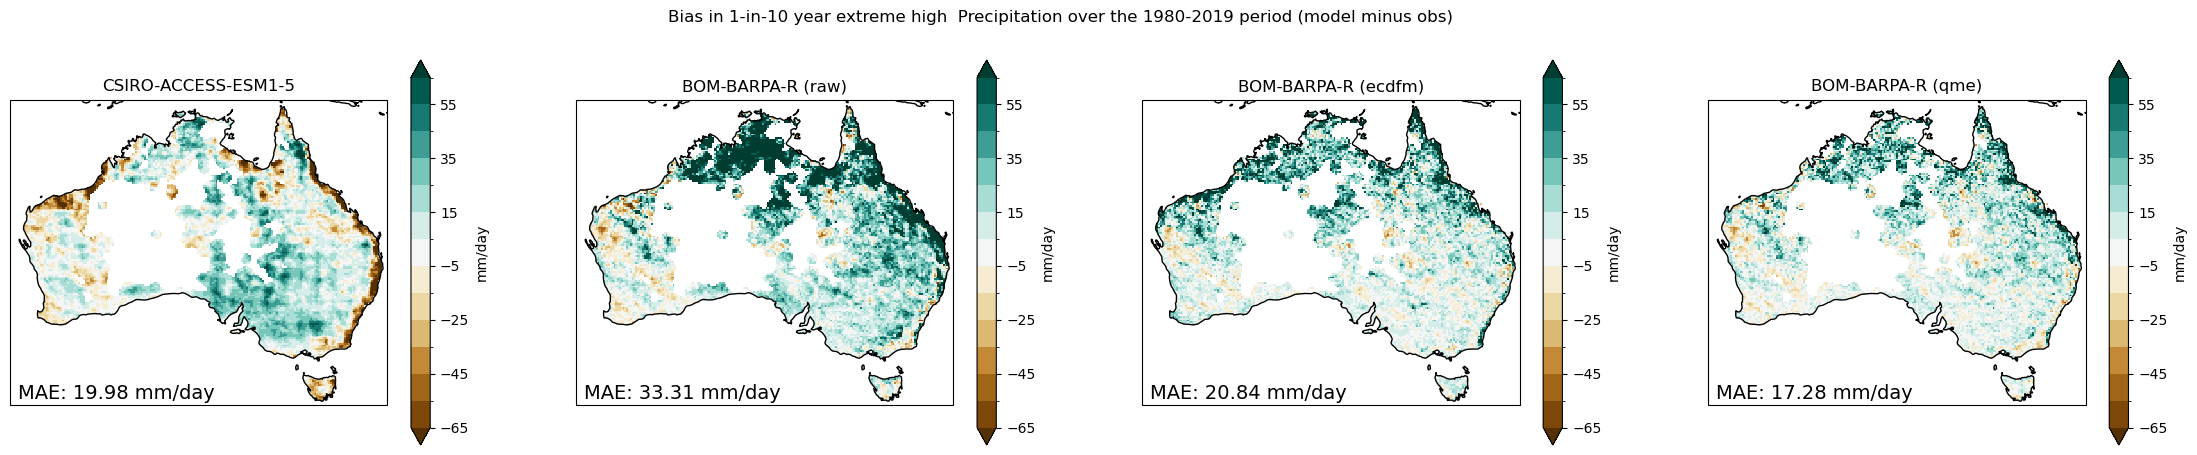

In [21]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'BOM-BARPA-R', 'historical', cmap, levels)

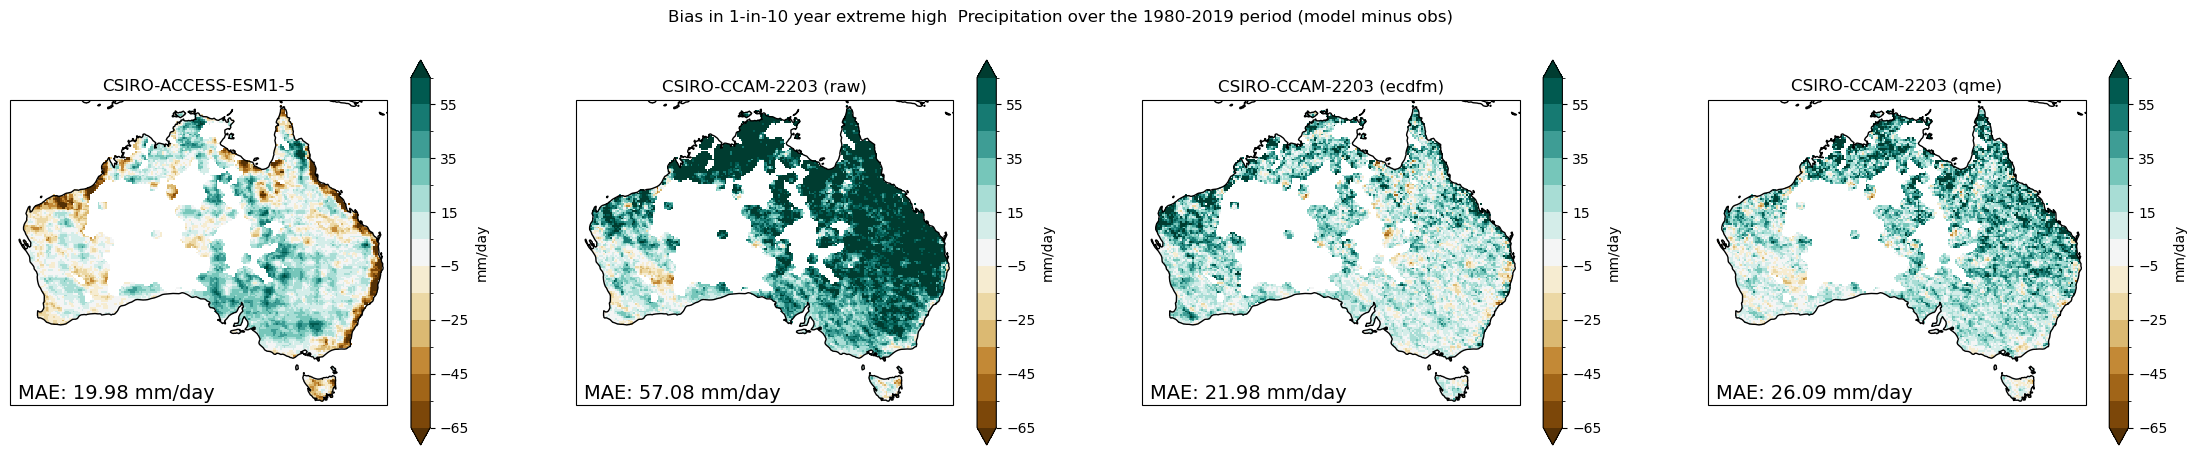

In [22]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'CSIRO-CCAM-2203', 'historical', cmap, levels)

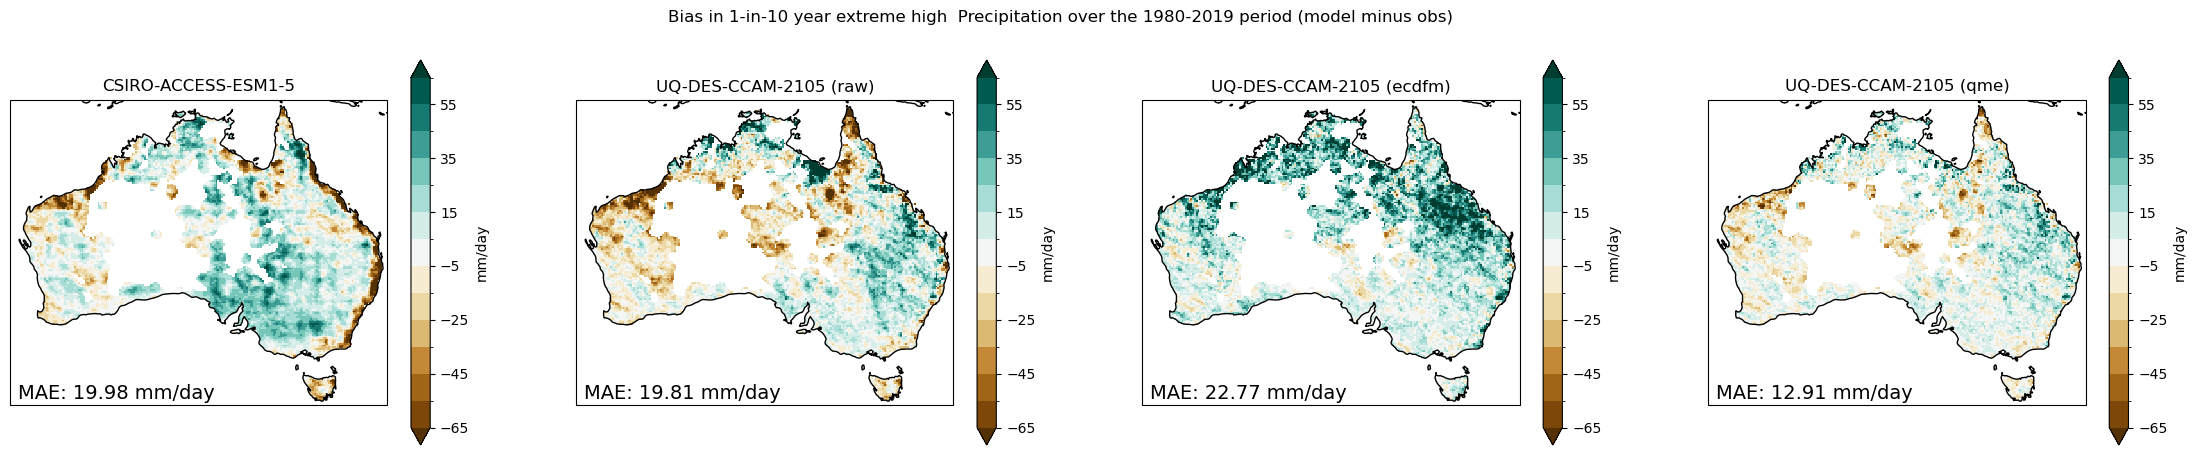

In [23]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'UQ-DES-CCAM-2105', 'historical', cmap, levels)

# task-xvalidation

### ERA5
Bias corrected data for the 2000-2019 period, using 1980-1999 as a training period.

In [ ]:
plot_comparison(variable, 'ECMWF-ERA5', 'BOM-BARPA-R', 'xvalidation', cmap, levels)

In [ ]:
plot_comparison(variable, 'ECMWF-ERA5', 'CSIRO-CCAM-2203', 'xvalidation', cmap, levels)

In [ ]:
plot_comparison(variable, 'ECMWF-ERA5', 'UQ-DES-CCAM-2105', 'xvalidation', cmap, levels)

### ACCESS-ESM1-5
Bias corrected data for the 1990-2019 period, using 1960-1989 as a training period.

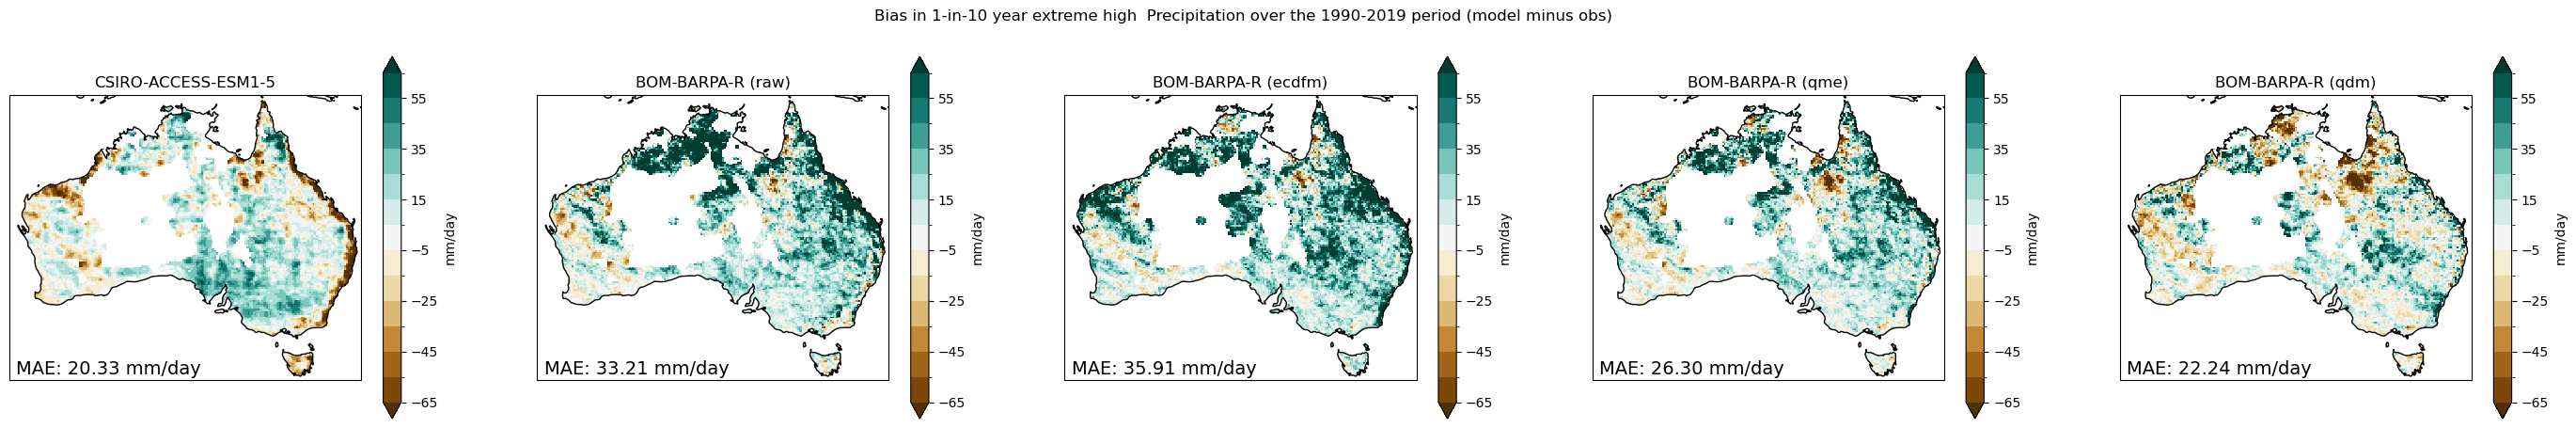

In [24]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'BOM-BARPA-R', 'xvalidation', cmap, levels)

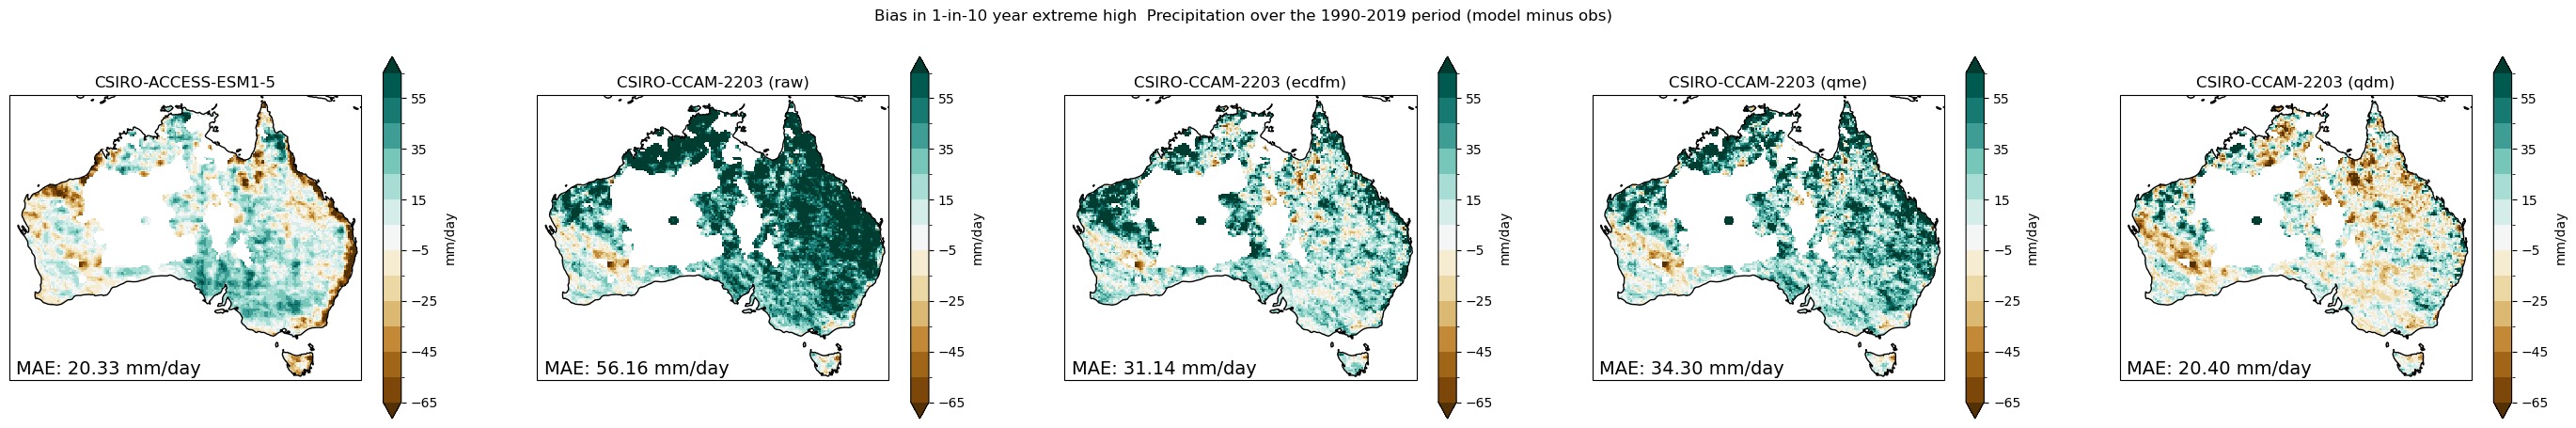

In [25]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'CSIRO-CCAM-2203', 'xvalidation', cmap, levels)

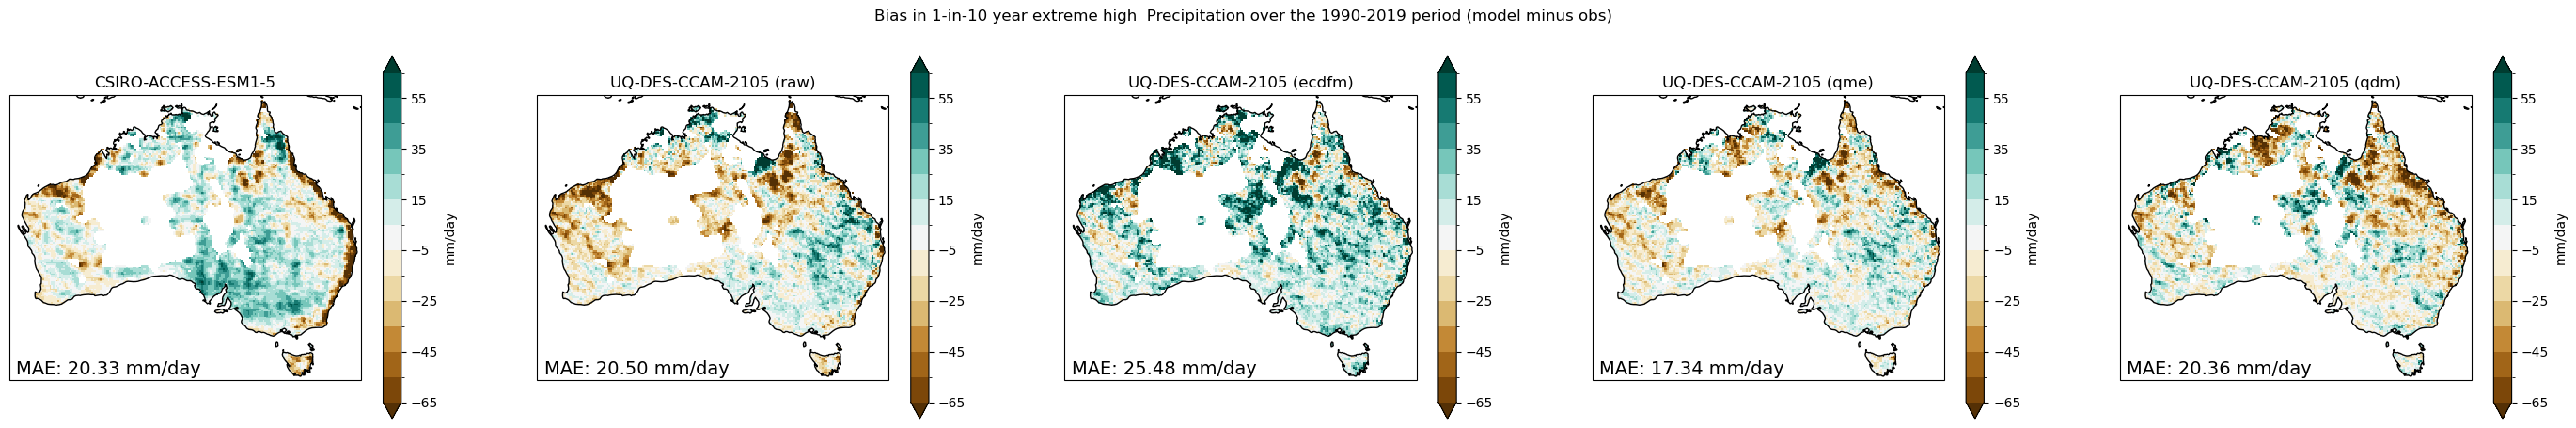

In [26]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'UQ-DES-CCAM-2105', 'xvalidation', cmap, levels)